# Exploration_SSAC 04 영화리뷰 텍스트 감성분석하기

영문 텍스트의 감정 분석을 기반으로 한국어 텍스트의 감정분석을 진행  
텍스트에 담긴 감성이 긍정적인지 / 부정적인지를 분류 (Classification)  

방법 자체는 영어 데이터에 대한 텍스트 분류와 크게 달라지지는 않지만, 한국어 데이터는 **토큰화(Tokenization)** 를 할 때, **형태소 분석기** 를 사용한다는 점이 다르다.

네이버 영화 리뷰 데이터는 총 200,000개 리뷰로 구성된 데이터로 영화 리뷰에 대한 텍스트와 해당 리뷰가 긍정인 경우 1을, 부정인 경우 0으로 표시한 레이블로 구성되어져 있다.

* Dataset : Naver sentiment movie corpus (nsmc 데이터 셋)  
* Model : RNN(LSTM), CNN(1D, 2D) 활용, 1-D CNN + RNN, FFN(FeedForward Network), Transfomer, word2vec 


##### 프로젝트 진행 순서  

1) 데이터 준비와 확인  
2) 데이터로더 구성  
3) 모델 구성을 위한 데이터 분석 및 가공  
4) 모델 구성 및 Validation set 구성  
5) 모델 훈련  
6) Loss, Accuracy 그래프 시각화  
7) 학습된 Embedding 레이어 분석  
8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

##### 필요한 모듈 import

In [92]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import os
from konlpy.tag import Okt
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant

### 1) 데이터 준비와 확인

https://github.com/e9t/nsmc/ 를 통하여 데이터 셋을 다운받는다.  
(프로젝트 별 폴더를 생성하여 데이터를 따로 저장)

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [3]:
train_data.label.unique() # label은 0,1로 구성 (0은 부정, 1은 긍정으로 분류)

array([0, 1])

In [4]:
print(train_data.size) # 45만 개의 평점 데이터
print(train_data.columns)

450000
Index(['id', 'document', 'label'], dtype='object')


In [5]:
test_data.size

150000

**데이터 분석**  
train_data의 경우, 45만 개의 데이터로 구성되어 있고, test_data의 경우, 15만 개의 데이터로 구성되어 있으며, 'id', 'document', 'label' 의 feature를 가지고 있다.  

하지만 모델 학습 과정에서 id는 불필요한 조건이기 때문에, 이후 제거하는 단계를 거친다.  
또한, label은 0과 1, 즉 긍정과 부정으로 분류되어 있다.  

마지막으로, 영어 텍스트 데이터와는 다르게 띄어쓰기를 하지 않아도 글을 이해하고, 분류할 수 있는 것을 알 수 있는데, 이는 한국어만의 특성이라 할 수 있다.

### 2) 데이터로더 구성

* 데이터의 중복 제거  
* NaN 결측치 제거  
* 한국어 토큰화  
* 불용어(Stopwords) 제거  
* 사전 word_to_index 구성  
* 텍스트 스트링을 사전 인덱스 스트링으로 변환  
* X_train, y_train, X_test, y_test, word_to_index 리턴   

이러한 기능을 가진 load_data 함수 정의  

불용어는 정의하기 나름인데, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수도 있겠지만 결국 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가하는 경우도 많다. 

In [6]:
tokenizer = Mecab() # Mecab 또는 Okt로 해결하기도 함.
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words = 10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace = True)
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word : index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}

* 인덱스를 key값으로 만들어 word dictionary 생성

In [19]:
print(len(index_to_word.values()))
print(index_to_word)

10000
{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '<UNUSED>', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 

##### 텍스트 데이터 변환 함수 정의

In [20]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

##### Embedding Layer

In [26]:
vocab_size = len(word_to_index) 
word_vector_dim = 8

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의
raw_inputs = np.array(get_encoded_sentences(train_data, word_to_index))
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[-0.00743668  0.00786952  0.00582372 -0.04595254  0.03443487
   -0.0205161   0.02386154 -0.00104889]
  [-0.01580961 -0.03657711  0.04829634  0.00145047  0.0056617
    0.01097018  0.00378876  0.02756615]
  [-0.02894372 -0.01285857  0.00450049 -0.04521751 -0.00827414
    0.02593825  0.03969479 -0.02320956]
  [-0.02894372 -0.01285857  0.00450049 -0.04521751 -0.00827414
    0.02593825  0.03969479 -0.02320956]
  [-0.02894372 -0.01285857  0.00450049 -0.04521751 -0.00827414
    0.02593825  0.03969479 -0.02320956]]

 [[-0.00743668  0.00786952  0.00582372 -0.04595254  0.03443487
   -0.0205161   0.02386154 -0.00104889]
  [-0.01580961 -0.03657711  0.04829634  0.00145047  0.0056617
    0.01097018  0.00378876  0.02756615]
  [-0.02894372 -0.01285857  0.00450049 -0.04521751 -0.00827414
    0.02593825  0.03969479 -0.02320956]
  [-0.02894372 -0.01285857  0.00450049 -0.04521751 -0.00827414
    0.02593825  0.03969479 -0.02320956]
  [-0.02894372 -0.01285857  0.00450049 -0.04521751 -0.00827414

pad_sequencs 를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 잊어서는 안된다.  

문장 최대 길이 maxlen 의 값 설정도 전체 모델 성능에 영향을 미치게 된다. 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋다.

In [27]:
total_data_text = list(X_train) + list(X_test)

# 텍스트 데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산해본다.
print("문장 길이의 평균 : ", np.mean(num_tokens))
print("문장 길이의 최대 : ", np.max(num_tokens))
print("문장 길이 표준 편차 : ", np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +4*np.std(num_tokens)
maxlen = int(max_tokens)
print("pad_sequences maxlen : ", maxlen)
print("전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.".format(np.sum(num_tokens<max_tokens)/len(num_tokens)))


문장 길이의 평균 :  15.96938143432699
문장 길이의 최대 :  116
문장 길이 표준 편차 :  12.843571939469296
pad_sequences maxlen :  67
전체 문장의 0.99755809131817%가 maxlen 설정값 이내에 포함됩니다.


In [37]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 67)
(49157, 67)


### 4) 모델 구성 및 Validation set 구성

##### Validation set 구성

In [34]:
len(X_train)

146182

In [39]:
# 대략 7:3 의 비율로 분리

# validation set 30000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 67)
(116182,)


#### 모델 구성

##### **model1 :: RNN**

In [45]:
vocab_size = len(word_to_index) 
word_vector_dim = 8

model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용
model1.add(keras.layers.Dense(32, activation='relu'))
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 

model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 154,545
Trainable params: 154,545
Non-trainable params: 0
_________________________________________________________________


##### model2 :: 1-D CNN

In [46]:
vocab_size = len(word_to_index) 
word_vector_dim = 8

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          912       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

##### **model3 :: GlobalMaxPooling1D()**

In [47]:
vocab_size = len(word_to_index) 
word_vector_dim = 8

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(32, activation='relu'))
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  

model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 8)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 9         
Total params: 80,561
Trainable params: 80,561
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련

##### Model01 :: RNN 학습

In [49]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 3s 13ms/step - loss: 0.6268 - accuracy: 0.5939 - val_loss: 0.3975 - val_accuracy: 0.8239
Epoch 2/20
227/227 [==============================] - 3s 11ms/step - loss: 0.3676 - accuracy: 0.8423 - val_loss: 0.3518 - val_accuracy: 0.8480
Epoch 3/20
227/227 [==============================] - 3s 11ms/step - loss: 0.3343 - accuracy: 0.8592 - val_loss: 0.3517 - val_accuracy: 0.8490
Epoch 4/20
227/227 [==============================] - 3s 11ms/step - loss: 0.3195 - accuracy: 0.8664 - val_loss: 0.3656 - val_accuracy: 0.8397
Epoch 5/20
227/227 [==============================] - 3s 11ms/step - loss: 0.3123 - accuracy: 0.8701 - val_loss: 0.3570 - val_accuracy: 0.8448
Epoch 6/20
227/227 [==============================] - 3s 11ms/step - loss: 0.3016 - accuracy: 0.8751 - val_loss: 0.3595 - val_accuracy: 0.8478
Epoch 7/20
227/227 [==============================] - 3s 11ms/step - loss: 0.2923 - accuracy: 0.8789 - val_loss: 0.3569 - val_accuracy: 0.8490

In [53]:
model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 3s 12ms/step - loss: 0.1526 - accuracy: 0.9429 - val_loss: 0.5104 - val_accuracy: 0.8369
Epoch 2/20
227/227 [==============================] - 3s 12ms/step - loss: 0.1486 - accuracy: 0.9447 - val_loss: 0.4905 - val_accuracy: 0.8382
Epoch 3/20
227/227 [==============================] - 3s 11ms/step - loss: 0.1467 - accuracy: 0.9458 - val_loss: 0.5220 - val_accuracy: 0.8348
Epoch 4/20
227/227 [==============================] - 3s 12ms/step - loss: 0.1449 - accuracy: 0.9462 - val_loss: 0.5420 - val_accuracy: 0.8380
Epoch 5/20
227/227 [==============================] - 3s 11ms/step - loss: 0.1431 - accuracy: 0.9471 - val_loss: 0.5023 - val_accuracy: 0.8387
Epoch 6/20
227/227 [==============================] - 3s 12ms/step - loss: 0.1407 - accuracy: 0.9480 - val_loss: 0.5777 - val_accuracy: 0.8383
Epoch 7/20
227/227 [==============================] - 3s 11ms/step - loss: 0.1391 - accuracy: 0.9489 - val_loss: 0.5383 - val_accuracy: 0.8384

* 테스트 셋으로 모델 평가

In [54]:
results1 = model1.evaluate(x_test,  y_test, verbose=2)

print(results1)

1537/1537 - 3s - loss: 0.5792 - accuracy: 0.8339
[0.5791759490966797, 0.833919882774353]


* model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장   
* 이를 그래프로 시각화를 해 보면 학습 과정을 볼 수 있고, 다양한 분석이 가능하다

In [55]:
history_dict1 = history1.history
print(history_dict1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Result of Model1 :: RNN

RNN의 기본 LSTM 레이어를 사용한 모델로서, Optimizer는 RMSprop(lr=0.001)을 사용하였고,   
epoch은 20, batch_size는 512로 학습시킨 결과,  

**정확도 83% 도달**

##### Model02 :: 1-D CNN 학습

In [58]:
model2.compile(#optimizer=tf.keras.optimizers.RMSprop(lr=0.001), # RNN과 달리, adam이 성능이 더 좋았다.
                optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 1s 5ms/step - loss: 0.1835 - accuracy: 0.9299 - val_loss: 0.4072 - val_accuracy: 0.8469
Epoch 2/20
227/227 [==============================] - 1s 4ms/step - loss: 0.1670 - accuracy: 0.9380 - val_loss: 0.4292 - val_accuracy: 0.8439
Epoch 3/20
227/227 [==============================] - 1s 4ms/step - loss: 0.1534 - accuracy: 0.9434 - val_loss: 0.4592 - val_accuracy: 0.8415
Epoch 4/20
227/227 [==============================] - 1s 4ms/step - loss: 0.1412 - accuracy: 0.9496 - val_loss: 0.4918 - val_accuracy: 0.8381
Epoch 5/20
227/227 [==============================] - 1s 4ms/step - loss: 0.1303 - accuracy: 0.9538 - val_loss: 0.5184 - val_accuracy: 0.8359
Epoch 6/20
227/227 [==============================] - 1s 4ms/step - loss: 0.1206 - accuracy: 0.9583 - val_loss: 0.5723 - val_accuracy: 0.8327
Epoch 7/20
227/227 [==============================] - 1s 4ms/step - loss: 0.1134 - accuracy: 0.9612 - val_loss: 0.5892 - val_accuracy: 0.8320
Epoch 

* 테스트 셋으로 모델 평가

In [59]:
results2 = model2.evaluate(x_test,  y_test, verbose=2)

print(results2)

1537/1537 - 4s - loss: 1.1291 - accuracy: 0.8110
[1.1291074752807617, 0.8109933733940125]


* model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장
* 이를 그래프로 시각화를 해 보면 학습 과정을 볼 수 있고, 다양한 분석이 가능하다

In [60]:
history_dict2 = history2.history
print(history_dict2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Result of Model2 :: 1-D CNN

1-D CNN 레이어를 사용하였고, Optimizer는 adam을 적용하였으며, epoch은 20, batch_size는 512로 학습시킨 결과,  

**정확도 81%**  

model01 RNN과 비교하여, 정확도는 크게 차이없지만, Loss값이 1이 넘어가는 결과가 나왔다.

##### Model03 :: GlobalMaxPooling1D() 학습

In [63]:
model3.compile( optimizer='adam',
                #optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2231 - accuracy: 0.9135 - val_loss: 0.4210 - val_accuracy: 0.8333
Epoch 2/20
227/227 [==============================] - 1s 3ms/step - loss: 0.2150 - accuracy: 0.9170 - val_loss: 0.4281 - val_accuracy: 0.8325
Epoch 3/20
227/227 [==============================] - 1s 3ms/step - loss: 0.2083 - accuracy: 0.9205 - val_loss: 0.4371 - val_accuracy: 0.8316
Epoch 4/20
227/227 [==============================] - 1s 3ms/step - loss: 0.2030 - accuracy: 0.9230 - val_loss: 0.4453 - val_accuracy: 0.8327
Epoch 5/20
227/227 [==============================] - 1s 3ms/step - loss: 0.1984 - accuracy: 0.9247 - val_loss: 0.4522 - val_accuracy: 0.8303
Epoch 6/20
227/227 [==============================] - 1s 3ms/step - loss: 0.1944 - accuracy: 0.9271 - val_loss: 0.4595 - val_accuracy: 0.8298
Epoch 7/20
227/227 [==============================] - 1s 3ms/step - loss: 0.1912 - accuracy: 0.9286 - val_loss: 0.4698 - val_accuracy: 0.8305
Epoch 

In [64]:
results3 = model3.evaluate(x_test,  y_test, verbose=2)

print(results3)

1537/1537 - 1s - loss: 0.5441 - accuracy: 0.8181
[0.5440789461135864, 0.8181337118148804]


In [65]:
history_dict3 = history3.history
print(history_dict3.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Result of Model3 :: GlobalMaxPooling1D

Conv 레이어 없이, GlobalMaxPooling1D 레이어를 사용한 모델로서, Optimizer는 Adam을 사용하였고, epoch 20, batch size 512로 학습시킨 결과,   

**정확도 81%**  

1-D CNN 모델과 정확도는 같지만, Loss값이 적게 나왔기 때문에,


결론적으로,  

**1-D CNN < GlobalMaxPooling1D < RNN 모델 순으로 정확도가 높게 나왔다.**

### 6) Loss, Accuracy 그래프 시각화

* Model01 :: RNN 

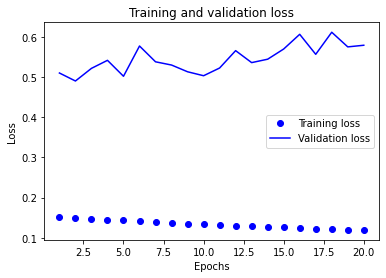

In [66]:
acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

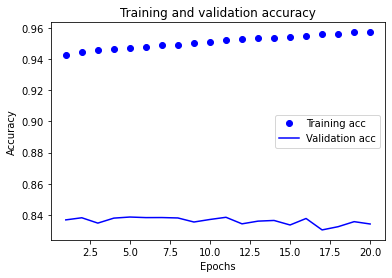

In [67]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* Model02 :: 1-D CNN

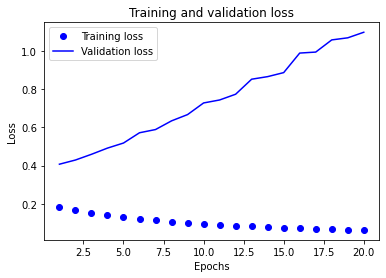

In [68]:
acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

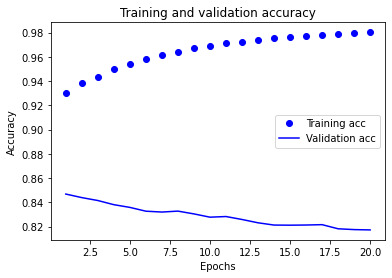

In [69]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

* Model03 :: GlobalMaxPooling1D

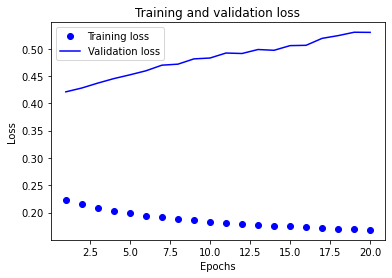

In [70]:
acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

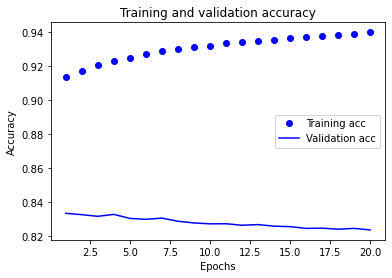

In [71]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

* 위에서 학습한 model1, model2, model3에서 Embedding 레이어에 학습된 워드 벡터들도 의미 공간상에 유의미한 형태로 학습이 되었을 것이다.

In [84]:
embedding_layer1 = model1.layers[0]
weights1 = embedding_layer1.get_weights()[0]
print(weights1.shape)    # shape: (vocab_size, embedding_dim)

(10000, 8)


In [85]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors1 = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors1[i, :])))))
f.close()

In [86]:
word_vectors1 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors1['인간']
vector

array([ 0.1828261 ,  0.07687726,  0.19334681, -0.07834671, -0.19377571,
        0.05971576,  0.08746445,  0.10114699], dtype=float32)

In [87]:
word_vectors1.similar_by_word("인간") # 과연 정교한 걸까...?

[('알려', 0.9455993175506592),
 ('안타까울', 0.935173749923706),
 ('테이크', 0.9316611289978027),
 ('최곤데', 0.9071351885795593),
 ('호불호', 0.8962482810020447),
 ('멜깁슨', 0.8962286710739136),
 ('인생', 0.8957219123840332),
 ('조용', 0.8910800218582153),
 ('류덕환', 0.8841937184333801),
 ('가진', 0.8771271109580994)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

Word2Vec은 구글에서 제공하는 Pretrained Word Embedding Model 이다.  

무려 1억개의 단어로 구성된 Google News Dataset을 바탕으로 학습되었고, 총 300만 개의 단어를 각각 300차원의 벡터로 표현한 것이다.   

다양한 언어로 학습된 Word2Vec이 있으며, https://github.com/Kyubyong/wordvectors 이 곳에서 다운로드 가능하다.

In [104]:
kor_word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'
# kor_word2vec = KeyedVectors.load_word2vec_format(kor_word2vec_path, binary=True, limit=10000)
# kor_vector = kor_word2vec['연기']
# kor_vector
# print(kor_vector.shape)

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

word2vec = Word2Vec.load(kor_word2vec_path)
ko_vector = word2vec['사람']
ko_vector

/home/ssac22/Downloads/exit/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


array([ 0.7412252 , -1.1187236 ,  2.0681474 ,  1.05749   , -1.3211275 ,
       -2.414994  , -1.133681  ,  1.5452526 , -0.4543698 ,  0.02380616,
        0.12370981, -0.8839078 , -2.9051683 , -0.34940982,  1.3418512 ,
        2.8225965 ,  1.0794274 ,  0.4287113 , -1.9613483 ,  0.4262147 ,
       -0.40650806, -0.34994036, -0.8416261 ,  0.52574843, -0.29543158,
       -0.5593075 ,  0.84687376,  0.0889315 , -2.5240638 ,  0.46828857,
        2.8982353 , -1.6508341 , -0.37446976, -2.2825975 ,  0.7083552 ,
       -0.59711653,  0.2839199 , -1.0247895 ,  2.3036754 ,  0.45918384,
       -0.83396995,  0.85293204,  0.972802  , -0.5457918 , -0.93798906,
       -0.8009529 ,  2.160266  ,  0.10052549, -0.16650781, -0.07592812,
       -0.45869842,  1.3352628 ,  2.3284414 ,  0.7132327 , -2.4690466 ,
        0.05213251,  0.38745207, -0.2773064 , -0.67375   , -0.59059584,
        1.0310122 ,  1.9923794 , -0.94680166, -1.3167765 , -1.4717319 ,
        0.97447944,  0.8103551 ,  0.8915873 ,  0.7474684 , -0.00

In [106]:
word2vec.similar_by_word("연기")

/home/ssac22/Downloads/exit/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('연출', 0.5039601922035217),
 ('뮤직비디오', 0.4684748649597168),
 ('주연', 0.4578327536582947),
 ('출연', 0.4573212265968323),
 ('안무', 0.4553908705711365),
 ('캐스팅', 0.43967586755752563),
 ('조연', 0.4288240373134613),
 ('단역', 0.42587459087371826),
 ('영화화', 0.4199691116809845),
 ('냄새', 0.41336026787757874)]

In [131]:
vocab_size = len(word_to_index) 
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/ssac22/Downloads/exit/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/ssac22/Downloads/exit/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [127]:
vocab_size = len(word_to_index) 
word_vector_dim = 200

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 67, 200)           2000000   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 61, 16)            22416     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 12, 16)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 6, 16)             1808      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 16)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_32 (Dense)             (None, 8)               

In [128]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 8s 34ms/step - loss: 0.5813 - accuracy: 0.6785 - val_loss: 0.4639 - val_accuracy: 0.7821
Epoch 2/20
227/227 [==============================] - 7s 33ms/step - loss: 0.4139 - accuracy: 0.8130 - val_loss: 0.3880 - val_accuracy: 0.8287
Epoch 3/20
227/227 [==============================] - 7s 32ms/step - loss: 0.3458 - accuracy: 0.8507 - val_loss: 0.3679 - val_accuracy: 0.8391
Epoch 4/20
227/227 [==============================] - 7s 32ms/step - loss: 0.3077 - accuracy: 0.8720 - val_loss: 0.3534 - val_accuracy: 0.8453
Epoch 5/20
227/227 [==============================] - 7s 33ms/step - loss: 0.2782 - accuracy: 0.8860 - val_loss: 0.3583 - val_accuracy: 0.8465
Epoch 6/20
227/227 [==============================] - 7s 32ms/step - loss: 0.2574 - accuracy: 0.8965 - val_loss: 0.3656 - val_accuracy: 0.8460
Epoch 7/20
227/227 [==============================] - 7s 32ms/step - loss: 0.2345 - accuracy: 0.9087 - val_loss: 0.3723 - val_accuracy: 0.8465

In [129]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6902 - accuracy: 0.8264
[0.6901546120643616, 0.8263522982597351]


### Result of Project

이번 프로젝트에서는 (물론 모든 NLP 프로젝트가 그럴 수도 있지만) 데이터 모델을 정교하게 짜는 것보다도 데이터 전처리 과정이 가장 중요하게 작용하였다.  

텍스트를 컴퓨터 언어로 바꾸기 위한 과정에서, **토큰화** 과정을 거쳐야 했고, 이를 다시 벡터화하여 데이터를 가공하는 과정에서 어려움을 겪었다.  

또한, NLP에서 활용되는 다양한 모델 중 가장 기본적인 RNN, 1-D CNN, GlobalMaxPooling 모델을 활용하여 모델을 생성하고, 학습 후 평가하는 과정에서 비슷하지만 또 다른 경향을 보이는 것을 알 수 있었다.   

유명한 pretrained model을 Embedding Layer에서 활용하면서 정확도 향상을 볼 수 있지만,   
이번에는 잘 적용되지 못했다.   

**정확도는 결과적으로 82% 까지 도달하였다.**

### Good

NLP 모델의 **네트워크 구조** 를 알 수 있는 기회였다.  
이미지에만 사용되는 줄 알았던 CNN 네트워크가 자연어 처리 과정에서도 활용된다는 점이 신기했고,  
그래서 더욱 더 이미지에 Transformer 모델을 적용해 보고 싶었다.  

또한, Pretrained model에 대하여 알아보고, 적용해보는 과정에서 확실히 word2vec이 더 잘 잡아내는 것을 알 수 있었다.

### Difficulties / Challenges

활용된 모든 모델의 네트워크 구조를 완벽하게 파악하지 않은 상태에서 적용하려고 하니, 각각의 레이어와 파라미터 값을 최적화하는 과정에서 어려움을 겪었다.  

* 토큰화 과정의 어려움  
* Padding / Embedding / Encode-Decode 코드화  
* 전반적인 네트워크 구조의 흐름  
* 다른 Embedding Pretrained model 의 활용 :: GloVe, FastText